# **Wine Quality Prediction**

##Setup: imports and useful functions



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import where
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.random import randint
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from six import StringIO  
import pydot
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import random

import copy #for deep copying
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


In [3]:
# Import utils
from utils.utils import *

CONFIG = read_yaml("CONFIG.yaml")

In [6]:
print(CONFIG)

{'APP': 'SEED = 0'}


In [8]:
# Fix random seed
random.seed(0)

In [9]:
!mkdir dataset
!wget -P dataset https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv  
!wget -P dataset https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv  

mkdir: dataset: File exists
--2021-10-20 15:14:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 84199 (82K) [application/x-httpd-php]
Сохранение в: «dataset/winequality-red.csv.10»

winequality-red.csv 100%[===================>]  82,23K   110KB/s    за 0,7s    

2021-10-20 15:15:02 (110 KB/s) - «dataset/winequality-red.csv.10» сохранён [84199/84199]

--2021-10-20 15:15:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 264426 (258K) [applicatio

## Dataset Analysis

In [10]:
data_wine_red = pd.read_csv('dataset/winequality-red.csv', ';')
data_wine_white = pd.read_csv('dataset/winequality-white.csv', ';')

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
data_wine_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [12]:
data_wine_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [13]:
print("Number of features in Math dataset: ", len(data_wine_red.columns))
print("Number of features in Portuguese dataset: ", len(data_wine_white.columns))

Number of features in Math dataset:  12
Number of features in Portuguese dataset:  12


In [14]:
# Check missing values
null_math = data_wine_red.isna().sum().sum()
null_port = data_wine_white.isna().sum().sum()
print("Missing values in Math dataset: ", null_math)
print("Missing values in Portuguese dataset: ", null_port)

Missing values in Math dataset:  0
Missing values in Portuguese dataset:  0


### Features Distribution

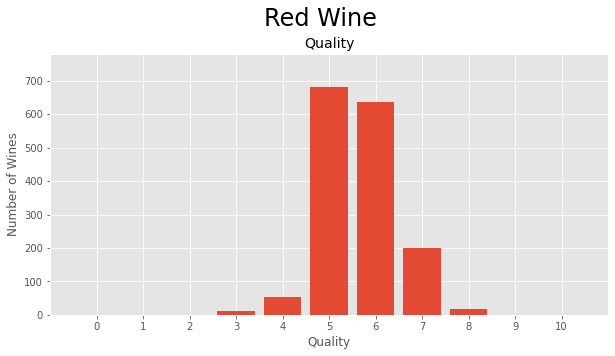

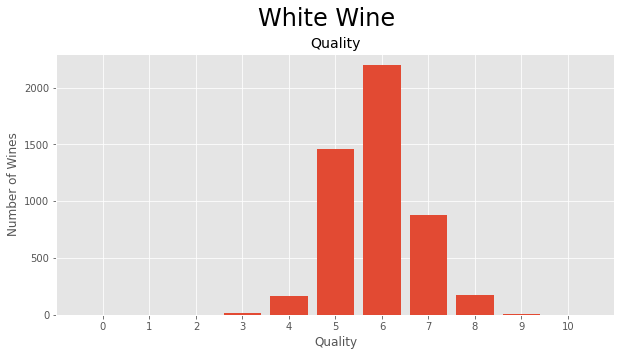

In [15]:
#quality distribution 
print_histograms(data_wine_red[['quality']].to_numpy(), title='Red Wine', subtitles='Quality')
print_histograms(data_wine_white[['quality']].to_numpy(), title='White Wine', subtitles='Quality')

/Users/degro/Code/Autumn3/DA/hw2/Wine_Quality_Prediction/utils/utils.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation.style.background_gradient(cmap='Blues').set_precision(2)


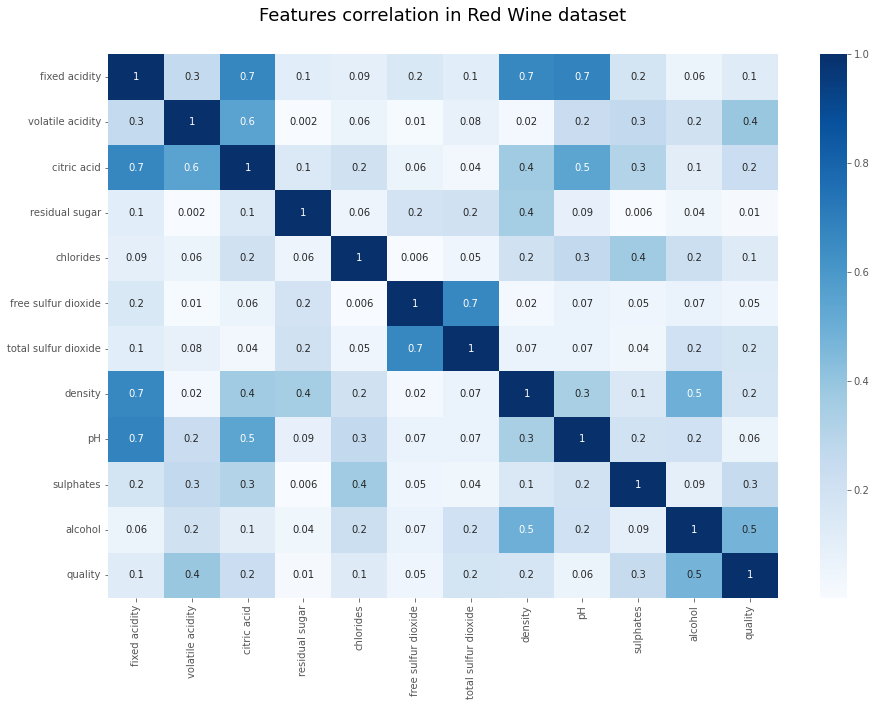

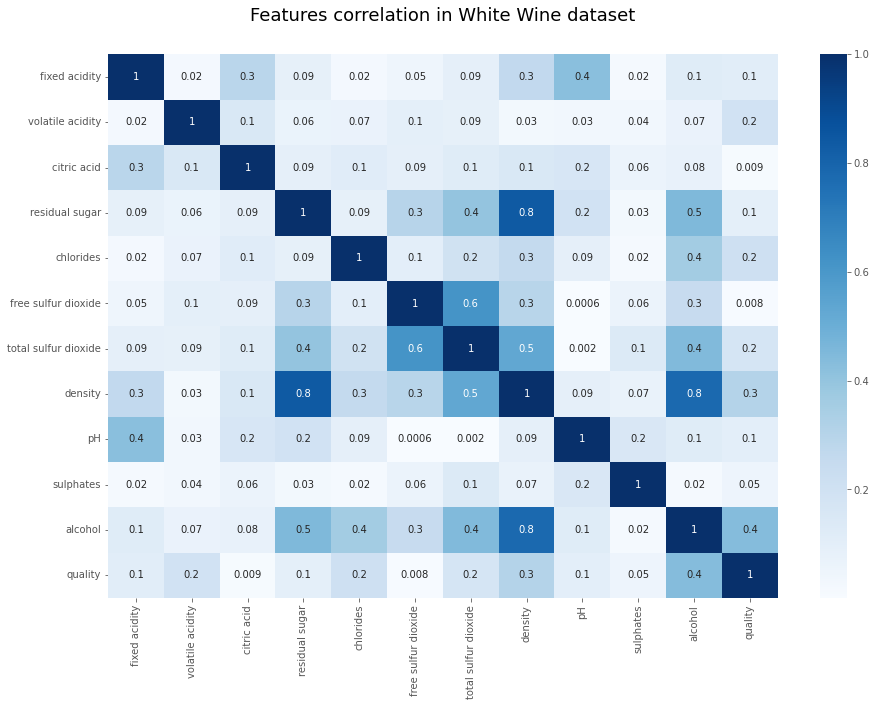

In [16]:
# Features correlation
print_correlation_matrix(data_wine_red.corr().abs(), 'Features correlation in Red Wine dataset')
print_correlation_matrix(data_wine_white.corr().abs(), 'Features correlation in White Wine dataset')

In [17]:
# Drop low correlated features to target ('quality')
threshold = 0.07
to_drop_red_wine = data_wine_red.corr().abs()['quality'] < threshold
to_drop_white_wine = data_wine_white.corr().abs()['quality'] < threshold
to_drop_red_wine = list((to_drop_red_wine[to_drop_red_wine]).index.values)
to_drop_white_wine = list((to_drop_white_wine[to_drop_white_wine]).index.values)
print("Candidate features to be dropped in Red Wine dataset: ", to_drop_red_wine)
print("Candidate features to be dropped in White Wine dataset: ", to_drop_white_wine)

Candidate features to be dropped in Red Wine dataset:  ['residual sugar', 'free sulfur dioxide', 'pH']
Candidate features to be dropped in White Wine dataset:  ['citric acid', 'free sulfur dioxide', 'sulphates']


In [18]:
data_wine_red = data_wine_red.drop(columns=to_drop_red_wine)
data_wine_white = data_wine_white.drop(columns=to_drop_white_wine)
print("Number of features in Red Wine dataset: ", len(data_wine_red.columns))
print("Number of features in White Wine dataset: ", len(data_wine_white.columns))

Number of features in Red Wine dataset:  9
Number of features in White Wine dataset:  9


## Data preprocessing and statistics

### Datasets statistics

#### Red Wine dataset statistics

Good:  53.47 %
Bad:  46.53 %
Counter({True: 855, False: 744})


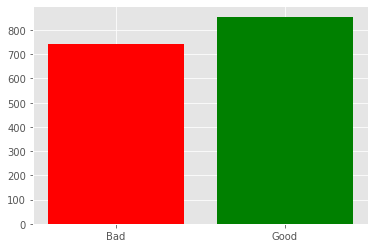

In [19]:
good_r = pd.value_counts(data_wine_red['quality'].values > 5 )[1]
print('Good: ', round(good_r/len(data_wine_red)*100, 2),'%')

bad_r = pd.value_counts( data_wine_red['quality'].values <= 5 )[1]
print('Bad: ', round(bad_r/len(data_wine_red)*100, 2),'%')

counter = Counter(data_wine_red['quality'].values > 5)
print(counter)

x = np.array(['Bad','Good'])
y = np.array([bad_r,good_r])
plt.bar(x, y, color=['red','green'])
plt.show()

#### White Wine dataset statistics

Good:  66.52 %
Bad:  33.48 %
Counter({True: 3258, False: 1640})


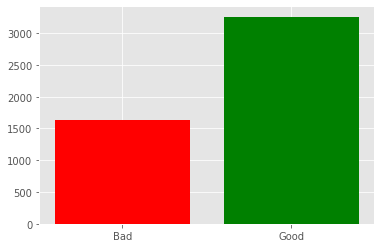

In [20]:
good_w = pd.value_counts(data_wine_white['quality'].values > 5 )[1]
print('Good: ', round(good_w/len(data_wine_white)*100, 2),'%')

bad_w = pd.value_counts( data_wine_white['quality'].values <= 5 )[1]
print('Bad: ', round(bad_w/len(data_wine_white)*100, 2),'%')

counter = Counter(data_wine_white['quality'].values > 5)
print(counter)

x = np.array(['Bad','Good'])
y = np.array([bad_w,good_w])
plt.bar(x, y, color=['red','green'])
plt.show()

#### Boxplot

In [21]:
def print_boxplots(X, Y, atributes=['Red wines', 'White wines'], y_val='quality', figsize=(15,5), title = 'Insert Title'):
  
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  fig.suptitle(title, fontsize=24, y=0.98)
  fig.subplots_adjust(top=0.85)
  
  sns.boxplot(y=y_val, data=X, ax=ax[0], showmeans=True, medianprops={'color':'yellow'})    
  ax[0].set_xlabel(atributes[0].capitalize()) 

  sns.boxplot(y=y_val, data=Y, ax=ax[1], showmeans=True, medianprops={'color':'yellow'})    
  ax[1].set_xlabel(atributes[1].capitalize())

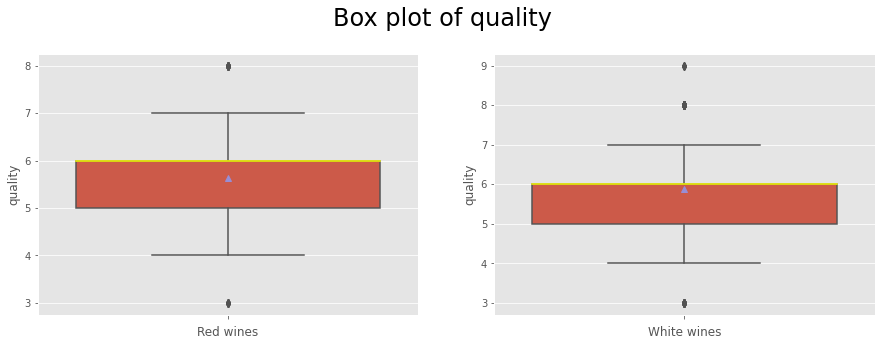

In [22]:
print_boxplots(data_wine_red, data_wine_white, title = 'Box plot of quality')

In [23]:
quality_red = data_wine_red['quality'].to_numpy()
quality_white = data_wine_white['quality'].to_numpy()

counter_r = Counter(data_wine_red['quality'].values)
counter_w = Counter(data_wine_white['quality'].values)

In [24]:
# creo l'insieme degli indici dei dati che sono considerati outliers. Questi set mi serviranno successivamente per la regressione
quality_r_3 = set(data_wine_red[data_wine_red['quality']==3].index) # red wines with wuality = 3
quality_r_8 = set(data_wine_red[data_wine_red['quality']==8].index) # red wines with wuality = 8
quality_r_out = quality_r_3.union(quality_r_8)

quality_w_3 = set(data_wine_white[data_wine_white['quality']==3].index) # white wines with wuality = 3
quality_w_8 = set(data_wine_white[data_wine_white['quality']==8].index) # white wines with wuality = 8
quality_w_9 = set(data_wine_white[data_wine_white['quality']==9].index) # white wines with wuality = 9
quality_w_out = quality_w_3.union(quality_w_8).union(quality_w_9)

### Train and Test set creation

In [25]:
# Create X and y
#print(data_wine_red.shape)
X_red_wine = data_wine_red[data_wine_red.columns.difference(['quality'])]
#print(X_red_wine.shape)
y_red_wine = data_wine_red['quality']

X_white_wine = data_wine_white[data_wine_white.columns.difference(['quality'])]
y_white_wine = data_wine_white['quality']

In [26]:
# Create train and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_red_wine, y_red_wine, test_size=0.2, stratify=y_red_wine, random_state=42) # 'stratify=y' allows to create a test split with an equal percentage
# of positive and negative labels
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_white_wine, y_white_wine, test_size=0.2, stratify=y_white_wine, random_state=42)

### Bootstrap and Feature Scaling


In [27]:
est_mean_train_r, est_dev_train_r, sem_train_r, err_std_train_r = estimate_mean_stdev_with_bootstrap(X_train_r, n_bootstraps=100)
est_mean_test_r, est_dev_test_r, sem_test_r, err_std_test_r = estimate_mean_stdev_with_bootstrap(X_test_r, n_bootstraps=100)

est_mean_train_w, est_dev_train_w, sem_train_w, err_std_train_w = estimate_mean_stdev_with_bootstrap(X_train_w, n_bootstraps=100, bootstrap_size=700)
est_mean_test_w, est_dev_test_w, sem_test_w, err_std_test_w = estimate_mean_stdev_with_bootstrap(X_test_w, n_bootstraps=100, bootstrap_size=700)

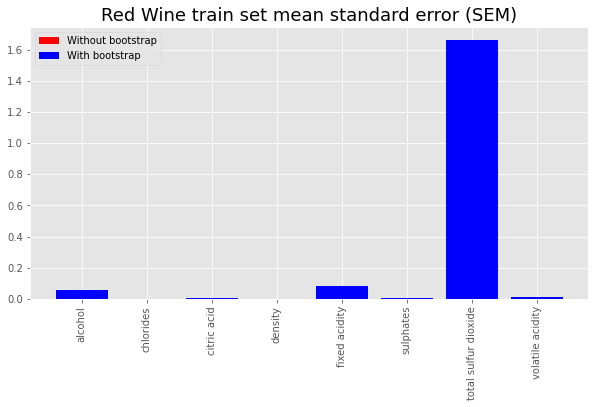

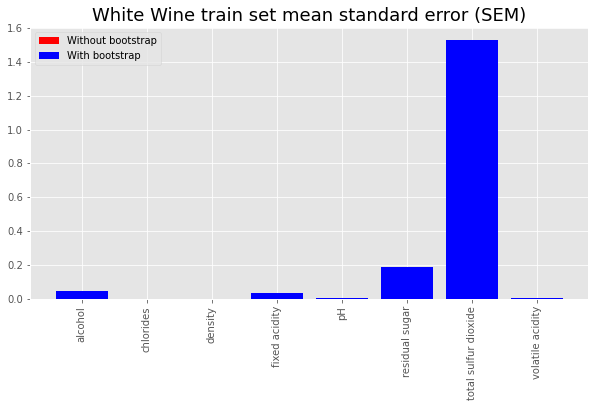

In [28]:
# SEM: measures how far the sample mean of the data is likely to be from the true population mean
plot_df_means(X_train_r.sem(), sem_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set mean standard error (SEM)')
plot_df_means(X_train_w.sem(), sem_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set mean standard error (SEM)')

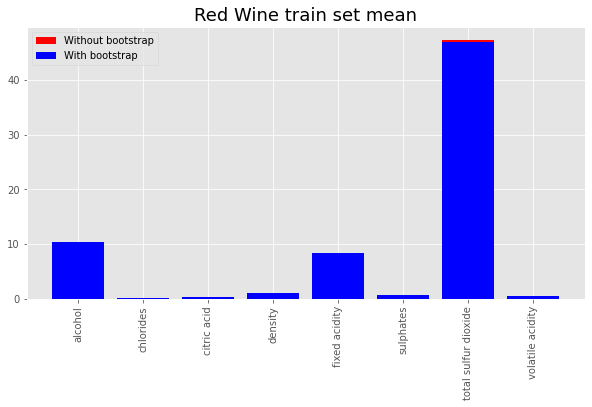

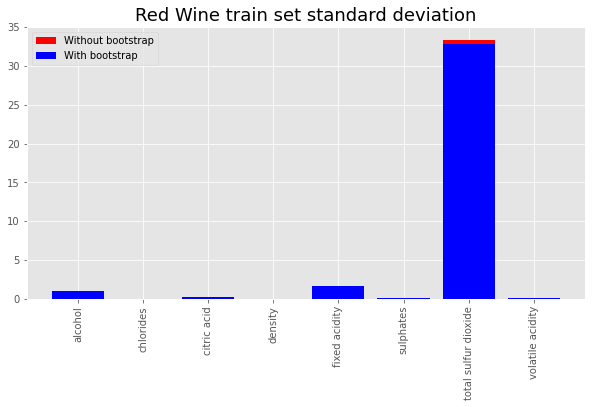

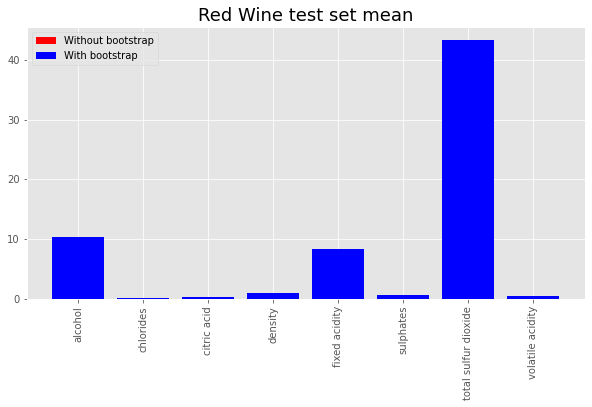

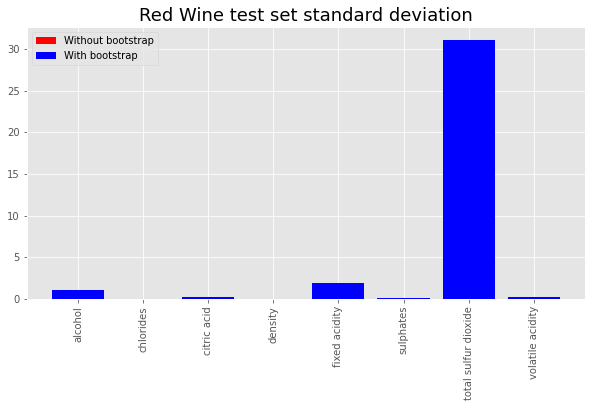

In [29]:
plot_df_means(X_train_r.mean(), est_mean_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set mean')
plot_df_means(X_train_r.std(), est_dev_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set standard deviation')
plot_df_means(X_test_r.mean(), est_mean_test_r, 'Without bootstrap','With bootstrap', 'Red Wine test set mean')
plot_df_means(X_test_r.std(), est_dev_test_r, 'Without bootstrap','With bootstrap', 'Red Wine test set standard deviation')

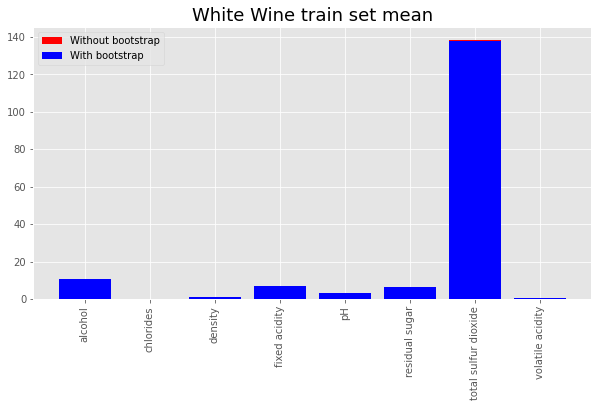

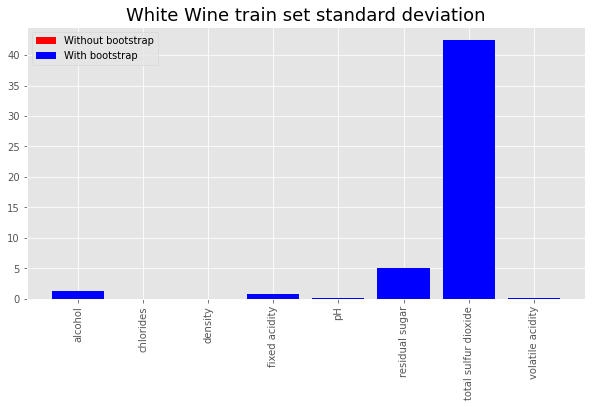

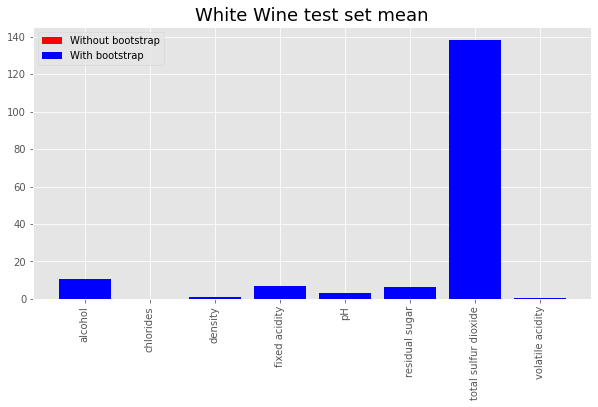

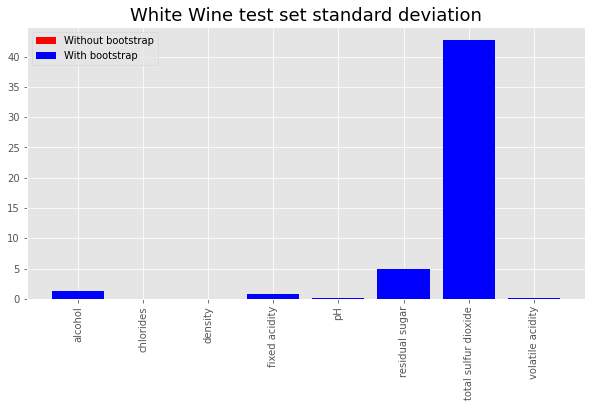

In [30]:
plot_df_means(X_train_w.mean(), est_mean_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set mean')
plot_df_means(X_train_w.std(), est_dev_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set standard deviation')
plot_df_means(X_test_w.mean(), est_mean_test_w, 'Without bootstrap','With bootstrap', 'White Wine test set mean')
plot_df_means(X_test_w.std(), est_dev_test_w, 'Without bootstrap','With bootstrap', 'White Wine test set standard deviation')

In [31]:
#Data standardization
X_train_r_std = (X_train_r - est_mean_train_r) / est_dev_train_r
X_test_r_std = (X_test_r - est_mean_test_r) / est_dev_test_r

X_train_w_std = (X_train_w - est_mean_train_w) / est_dev_train_w
X_test_w_std = (X_test_w - est_mean_test_w) / est_dev_test_w

### Principal Component Analysis (PCA)

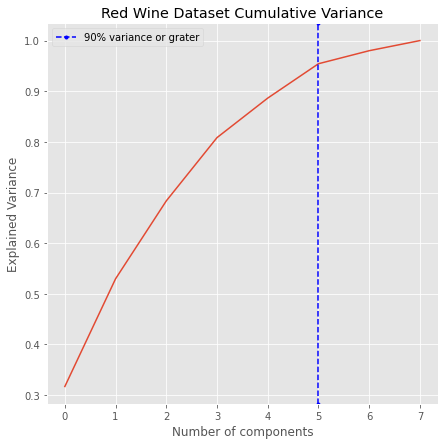

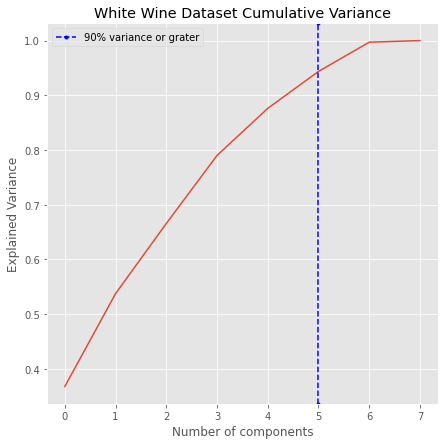

In [32]:
pca_r = PCA()
pca_w = PCA()
X_train_r_std_copy = copy.deepcopy(X_train_r_std)
X_test_r_std_copy = copy.deepcopy(X_test_r_std)
X_train_w_std_copy = copy.deepcopy(X_train_w_std)
X_test_w_std_copy = copy.deepcopy(X_test_w_std)

X_train_r_pca = pca_r.fit_transform(X_train_r_std_copy)
X_test_r_pca = pca_r.transform(X_test_r_std_copy)

X_train_w_pca = pca_w.fit_transform(X_train_w_std_copy)
X_test_w_pca = pca_w.transform(X_test_w_std_copy)

n_PC_90th_r = plot_explained_variance(pca_r.explained_variance_ratio_, 'Red Wine Dataset Cumulative Variance')
n_PC_90th_w = plot_explained_variance(pca_w.explained_variance_ratio_, 'White Wine Dataset Cumulative Variance')

In [33]:
n_PC_90th_r = int(n_PC_90th_r)
n_PC_90th_w = int(n_PC_90th_w)

X_train_r_reduced = pd.DataFrame(X_train_r_pca[:,:n_PC_90th_r], columns=[f'PC{i}' for i in range(n_PC_90th_r)], index = X_train_r_std.index)
X_train_w_reduced = pd.DataFrame(X_train_w_pca[:,:n_PC_90th_w], columns=[f'PC{i}' for i in range(n_PC_90th_w)], index = X_train_w_std.index)

X_test_r_reduced = pd.DataFrame(X_test_r_pca[:,:n_PC_90th_r], columns=[f'PC{i}' for i in range(n_PC_90th_r)], index = X_test_r_std.index)
X_test_w_reduced = pd.DataFrame(X_test_w_pca[:,:n_PC_90th_w], columns=[f'PC{i}' for i in range(n_PC_90th_w)], index = X_test_w_std.index)

### Output conversion

In [34]:
# Recreate datasets
y_train_r_bin = copy.deepcopy(y_train_r)

y_test_r_bin = y_test_r.copy()
y_train_w_bin = y_train_w.copy()
y_test_w_bin = y_test_w.copy()

# 'quality' becomes a binary label: 0 = bad; 1 = good
y_train_r_bin = np.where(y_train_r_bin > 5, 1, 0)
y_test_r_bin = np.where(y_test_r_bin > 5, 1, 0)

y_train_w_bin = np.where(y_train_w_bin > 5, 1, 0)
y_test_w_bin = np.where(y_test_w_bin > 5, 1, 0)

### Dataset Oversampling: ADASYN Algorithm (Adaptive Synthetic Sampling Method for Imbalanced Data)
Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.

In [35]:
sampler = ADASYN(sampling_strategy='minority', random_state=0)

print("###### White Wine dataset ######")
print(Counter(y_train_w_bin))
X_ADASYN_w, y_ADASYN_w = sampler.fit_resample(X_train_w_reduced, y_train_w_bin)
print(Counter(y_ADASYN_w))

###### White Wine dataset ######
Counter({1: 2606, 0: 1312})
Counter({1: 2606, 0: 2447})


## Classification

Proposed algorithms:
1. Logistic Regression
2. SVM

The classification algorithms will be trained on both oversampled and not oversampled sets and the obtained results will be compared.

In [36]:
def classification(X_train, y_train, X_test, y_test, clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

In [37]:
def print_classification_report(X_train, y_train, X_test, y_test, clf):
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

### Logistic Regression

In [38]:
LR_acc= np.zeros((1,3))
LR_f1= np.zeros((1,3))

#### PCA-reduced dataset

######### Red Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'C': 0.01}
accuracy Red Wine:
0.715625
F1 score Red Wine:
0.6996699669966997
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       149
           1       0.74      0.72      0.73       171

    accuracy                           0.72       320
   macro avg       0.71      0.72      0.71       320
weighted avg       0.72      0.72      0.72       320



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


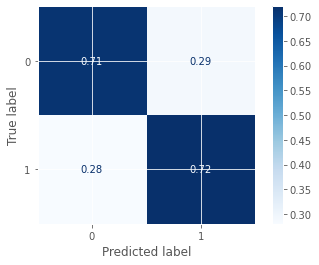

In [39]:
# Parameters Tuning
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


print("######### Red Wine dataset #########")
clf_r = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_r = GridSearchCV(clf_r, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_r.fit(X_train_r_reduced, y_train_r_bin).score(X_test_r_reduced, y_test_r_bin)
y_pred = clf_r.predict(X_test_r_reduced)
LR_acc[0,0] = acc
F1 = f1_score(y_test_r_bin, y_pred, average=None)
LR_f1[0,0] = F1[0]

print(clf_r.best_params_)
print("accuracy Red Wine:")
print(acc)
print("F1 score Red Wine:")
print(F1[0])
print_classification_report(X_train_r_reduced, y_train_r_bin, X_test_r_reduced, y_test_r_bin, clf_r)

######### White Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'C': 1}
accuracy White Wine:
0.710204081632653
F1 score White Wine:
0.43199999999999994
              precision    recall  f1-score   support

           0       0.63      0.33      0.43       328
           1       0.73      0.90      0.81       652

    accuracy                           0.71       980
   macro avg       0.68      0.62      0.62       980
weighted avg       0.69      0.71      0.68       980



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


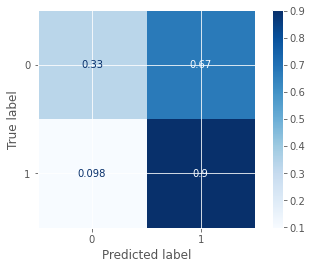

In [40]:
print("######### White Wine dataset #########")
clf_w = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_train_w_reduced, y_train_w_bin).score(X_test_w_reduced, y_test_w_bin)
y_pred = clf_w.predict(X_test_w_reduced)
LR_acc[0,1] = acc
F1 = f1_score(y_test_w_bin, y_pred, average=None)
LR_f1[0,1] = F1[0]

print(clf_w.best_params_)
print("accuracy White Wine:")
print(acc)
print("F1 score White Wine:")
print(F1[0])
print_classification_report(X_train_w_reduced, y_train_w_bin, X_test_w_reduced, y_test_w_bin, clf_w)

#### PCA-reduced dataset and oversampled train set 

######### White Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'C': 0.1}
accuracy White Wine adasyn:
0.7071428571428572
F1 score White Wine adasyn:
0.6084583901773533
              precision    recall  f1-score   support

           0       0.55      0.68      0.61       328
           1       0.82      0.72      0.77       652

    accuracy                           0.71       980
   macro avg       0.68      0.70      0.69       980
weighted avg       0.73      0.71      0.71       980



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


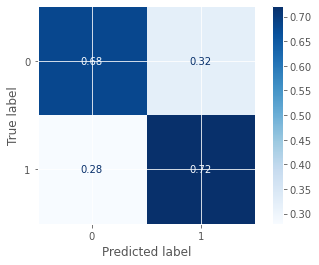

In [41]:
print("######### White Wine dataset #########")
clf_w = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_ADASYN_w, y_ADASYN_w).score(X_test_w_reduced, y_test_w_bin)
y_pred = clf_w.predict(X_test_w_reduced)
LR_acc[0,2] = acc
F1 = f1_score(y_test_w_bin, y_pred, average=None)
LR_f1[0,2] = F1[0]

print(clf_w.best_params_)
print("accuracy White Wine adasyn:")
print(acc)
print("F1 score White Wine adasyn:")
print(F1[0])
print_classification_report(X_ADASYN_w, y_ADASYN_w, X_test_w_reduced, y_test_w_bin, clf_w)

In [42]:
LR_acc_scores = pd.DataFrame(np.round(LR_acc, decimals = 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['Logistic Regression'])
LR_acc_scores 

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.72,0.71,0.71


In [43]:
LR_f1_scores = pd.DataFrame(np.round(LR_f1, decimals = 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['Logistic Regression'])
LR_f1_scores 

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.7,0.43,0.61


### Support Vector Machines

#### PCA-reduced dataset

In [44]:
SVM_acc_linear = np.zeros((1,3))
SVM_f1_linear = np.zeros((1,3))

SVM_acc_rbf = np.zeros((1,3))
SVM_f1_rbf = np.zeros((1,3))

params_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
params_grid_rbf    = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [10**(-7), 10**(-5), 10**(-3), 10**(-1), 0.5, 1, 10, 100]}

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 56 candidates, totalling 280 fits
######### Linear kernel param (Red Wine) #########
{'C': 1}
accuracy: 
0.70625
F1 score: 
0.6987179487179488
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       149
           1       0.75      0.68      0.71       171

    accuracy                           0.71       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.71      0.71      0.71       320

######### RBF kernel param (Red Wine) #########
{'C': 1, 'gamma': 0.5}
accuracy: 
0.709375
F1 score: 
0.6868686868686869
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       149
           1       0.73      0.73      0.73       171

    accuracy                           0.71       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.71      0.71      0.71      

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


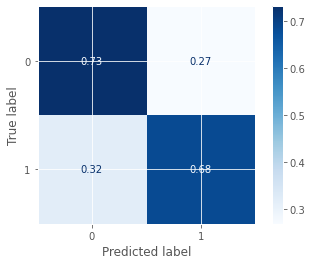

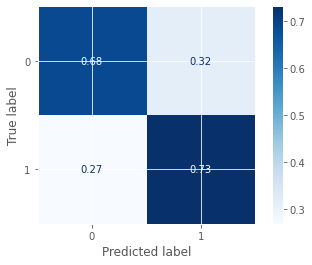

In [45]:
## Linear Kernel
clf_r_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_r_linear = GridSearchCV(clf_r_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_r_linear.fit(X_train_r_reduced, y_train_r_bin).score(X_test_r_reduced, y_test_r_bin)
y_pred_linear = clf_r_linear.predict(X_test_r_reduced)

SVM_acc_linear[0,0] = acc_linear
F1_linear = f1_score(y_test_r_bin, y_pred_linear, average=None)
SVM_f1_linear[0,0] = F1_linear[0]

## RBF kernel
clf_r_rbf = SVC(kernel = 'rbf')
clf_r_rbf = GridSearchCV(clf_r_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_r_rbf.fit(X_train_r_reduced, y_train_r_bin).score(X_test_r_reduced, y_test_r_bin)
y_pred_rbf = clf_r_rbf.predict(X_test_r_reduced)

SVM_acc_rbf[0,0] = acc_rbf
F1_rbf = f1_score(y_test_r_bin, y_pred_rbf, average=None)
SVM_f1_rbf[0,0] = F1_rbf[0]

print("######### Linear kernel param (Red Wine) #########")
print(clf_r_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print('F1 score: ')
print(F1_linear[0])
print_classification_report(X_train_r_reduced, y_train_r_bin, X_test_r_reduced, y_test_r_bin, clf_r_linear)



print("######### RBF kernel param (Red Wine) #########")
print(clf_r_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print('F1 score: ')
print(F1_rbf[0])
print_classification_report(X_train_r_reduced, y_train_r_bin, X_test_r_reduced, y_test_r_bin, clf_r_rbf)

           PC0       PC1       PC2       PC3       PC4
963   0.791917  1.632825  0.692279 -0.257018 -0.546171
475   0.449290 -0.852100 -0.717092 -0.854185  0.515096
1    -1.009538 -1.945933  0.903281 -0.321623  0.958038
329   1.178424  0.025608 -1.527616 -0.421665 -0.500481
149   0.797403  0.404653 -0.041069  0.228711 -0.409417
...        ...       ...       ...       ...       ...
1173  0.341900 -0.298813  0.093399  0.982048 -1.056500
827  -1.141580  0.265991 -0.471696  0.092803 -0.556069
356   2.998182  0.545561  0.054311  0.229108  0.989180
1287 -2.829918  2.185046 -1.295718 -0.583419  0.913815
789   0.057847 -2.246311  0.240079  1.686656  0.228157

[320 rows x 5 columns]
n_features:  5
           PC0       PC1       PC2       PC3       PC4
963   0.791917  1.632825  0.692279 -0.257018 -0.546171
475   0.449290 -0.852100 -0.717092 -0.854185  0.515096
1    -1.009538 -1.945933  0.903281 -0.321623  0.958038
329   1.178424  0.025608 -1.527616 -0.421665 -0.500481
149   0.797403  0.404653 -

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


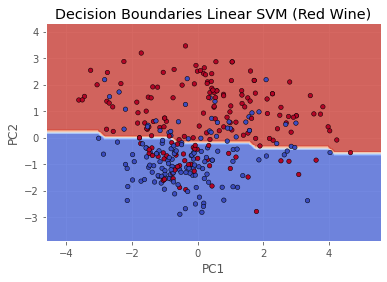

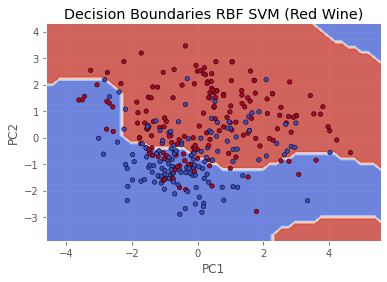

In [46]:
decision_boundaries(X_test_r_reduced, y_test_r_bin, 'Decision Boundaries Linear SVM (Red Wine)', clf_r_linear)
decision_boundaries(X_test_r_reduced, y_test_r_bin, 'Decision Boundaries RBF SVM (Red Wine)', clf_r_rbf)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 56 candidates, totalling 280 fits
######### Linear kernel param (White Wine) #########
{'C': 100}
accuracy: 
0.676530612244898
F1 score: 
0.20551378446115287
              precision    recall  f1-score   support

           0       0.58      0.12      0.21       328
           1       0.68      0.95      0.80       652

    accuracy                           0.68       980
   macro avg       0.63      0.54      0.50       980
weighted avg       0.65      0.68      0.60       980

######### RBF kernel param (White Wine) #########
{'C': 1, 'gamma': 1}
accuracy: 
0.7275510204081632
F1 score: 
0.5257548845470693


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.63      0.45      0.53       328
           1       0.76      0.87      0.81       652

    accuracy                           0.73       980
   macro avg       0.69      0.66      0.67       980
weighted avg       0.72      0.73      0.71       980



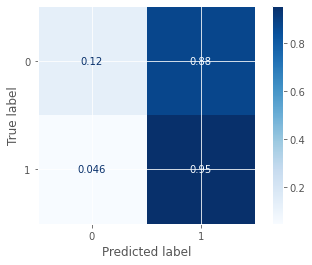

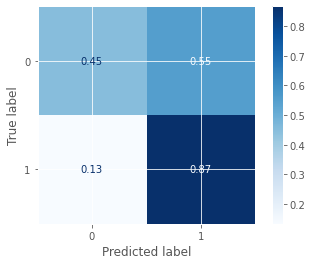

In [47]:
## Linear Kernel
clf_w_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_w_linear = GridSearchCV(clf_w_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_w_linear.fit(X_train_w_reduced, y_train_w_bin).score(X_test_w_reduced, y_test_w_bin)
y_pred_linear = clf_w_linear.predict(X_test_w_reduced)

SVM_acc_linear[0,1] = acc_linear
F1_linear = f1_score(y_test_w_bin, y_pred_linear, average=None)
SVM_f1_linear[0,1] = F1_linear[0]

## RBF kernel
clf_w_rbf = SVC(kernel = 'rbf')
clf_w_rbf = GridSearchCV(clf_w_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_w_rbf.fit(X_train_w_reduced, y_train_w_bin).score(X_test_w_reduced, y_test_w_bin)
y_pred_rbf = clf_w_rbf.predict(X_test_w_reduced)

SVM_acc_rbf[0,1] = acc_rbf
F1_rbf = f1_score(y_test_w_bin, y_pred_rbf, average=None)
SVM_f1_rbf[0,1] = F1_rbf[0]

print("######### Linear kernel param (White Wine) #########")
print(clf_w_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print('F1 score: ')
print(F1_linear[0])
print_classification_report(X_train_w_reduced, y_train_w_bin, X_test_w_reduced, y_test_w_bin, clf_w_linear)


print("######### RBF kernel param (White Wine) #########")
print(clf_w_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print('F1 score: ')
print(F1_rbf[0])
print_classification_report(X_train_w_reduced, y_train_w_bin, X_test_w_reduced, y_test_w_bin, clf_w_rbf)

           PC0       PC1       PC2       PC3       PC4
1740  0.941074 -0.273844  0.944024  0.213442 -0.247147
2658  1.266413 -0.872687 -1.301164  0.074898 -0.416707
1203 -1.992018 -2.653752  0.438404  0.229980 -0.534118
3985  0.156567  0.030842 -1.634888  0.632673 -0.744229
2945 -3.831817 -1.619658  0.483537 -1.258687  0.152858
...        ...       ...       ...       ...       ...
4393  1.444090 -0.822686 -1.262062 -0.549821 -1.147473
1454  4.577629  1.255990 -0.948418 -0.634417  0.309092
2576  1.799633 -0.819095 -0.351655 -0.563984  0.652635
4501  2.205034 -1.538685  1.761575 -1.915914 -0.081397
3638 -2.746596  0.125430 -0.205705 -0.883636 -0.230475

[980 rows x 5 columns]
n_features:  5
           PC0       PC1       PC2       PC3       PC4
1740  0.941074 -0.273844  0.944024  0.213442 -0.247147
2658  1.266413 -0.872687 -1.301164  0.074898 -0.416707
1203 -1.992018 -2.653752  0.438404  0.229980 -0.534118
3985  0.156567  0.030842 -1.634888  0.632673 -0.744229
2945 -3.831817 -1.619658  

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


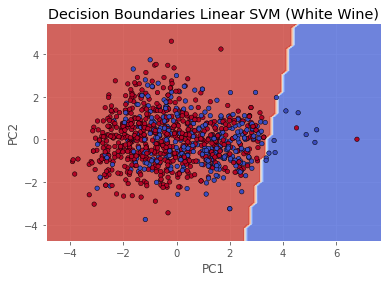

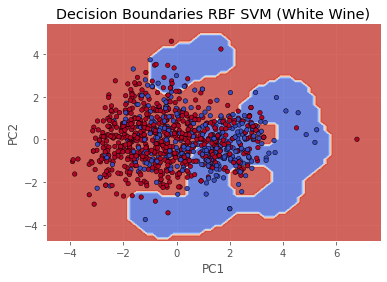

In [48]:
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries Linear SVM (White Wine)', clf_w_linear)
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries RBF SVM (White Wine)', clf_w_rbf)

#### PCA-reduced dataset and oversampled train set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 56 candidates, totalling 280 fits
######### Linear kernel param (White Wine adasyn)#########
{'C': 1}
accuracy: 
0.689795918367347
F1 score: 
0.6051948051948052
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       328
           1       0.82      0.68      0.74       652

    accuracy                           0.69       980
   macro avg       0.68      0.69      0.67       980
weighted avg       0.72      0.69      0.70       980

######### RBF kernel param (White Wine adasyn)#########
{'C': 10, 'gamma': 10}
accuracy: 
0.7724489795918368
F1 score: 
0.5800376647834274


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.47      0.58       328
           1       0.78      0.92      0.84       652

    accuracy                           0.77       980
   macro avg       0.77      0.70      0.71       980
weighted avg       0.77      0.77      0.76       980



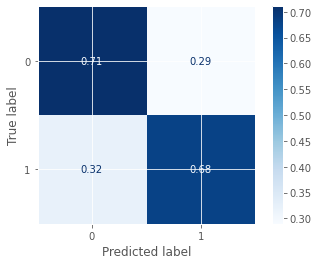

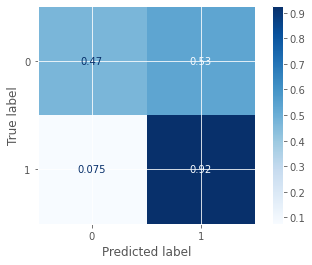

In [49]:
## Linear Kernel
clf_w_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_w_linear = GridSearchCV(clf_w_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_w_linear.fit(X_ADASYN_w, y_ADASYN_w).score(X_test_w_reduced, y_test_w_bin)
y_pred_linear = clf_w_linear.predict(X_test_w_reduced)

SVM_acc_linear[0,2] = acc_linear
F1_linear = f1_score(y_test_w_bin, y_pred_linear, average=None)
SVM_f1_linear[0,2] = F1_linear[0]


# RBF Kernel
clf_w_rbf = SVC(kernel = 'rbf')
clf_w_rbf = GridSearchCV(clf_w_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_w_rbf.fit(X_ADASYN_w, y_ADASYN_w).score(X_test_w_reduced, y_test_w_bin)
y_pred_rbf = clf_w_rbf.predict(X_test_w_reduced)

SVM_acc_rbf[0,2] = acc_rbf 
F1_rbf = f1_score(y_test_w_bin, y_pred_rbf, average=None)
SVM_f1_rbf[0,2] = F1_rbf[0]

print("######### Linear kernel param (White Wine adasyn)#########")
print(clf_w_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print('F1 score: ')
print(F1_linear[0])
print_classification_report(X_ADASYN_w, y_ADASYN_w, X_test_w_reduced, y_test_w_bin, clf_w_linear)

print("######### RBF kernel param (White Wine adasyn)#########")
print(clf_w_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print('F1 score: ')
print(F1_rbf[0])
print_classification_report(X_ADASYN_w, y_ADASYN_w, X_test_w_reduced, y_test_w_bin, clf_w_rbf)

           PC0       PC1       PC2       PC3       PC4
1740  0.941074 -0.273844  0.944024  0.213442 -0.247147
2658  1.266413 -0.872687 -1.301164  0.074898 -0.416707
1203 -1.992018 -2.653752  0.438404  0.229980 -0.534118
3985  0.156567  0.030842 -1.634888  0.632673 -0.744229
2945 -3.831817 -1.619658  0.483537 -1.258687  0.152858
...        ...       ...       ...       ...       ...
4393  1.444090 -0.822686 -1.262062 -0.549821 -1.147473
1454  4.577629  1.255990 -0.948418 -0.634417  0.309092
2576  1.799633 -0.819095 -0.351655 -0.563984  0.652635
4501  2.205034 -1.538685  1.761575 -1.915914 -0.081397
3638 -2.746596  0.125430 -0.205705 -0.883636 -0.230475

[980 rows x 5 columns]
n_features:  5
           PC0       PC1       PC2       PC3       PC4
1740  0.941074 -0.273844  0.944024  0.213442 -0.247147
2658  1.266413 -0.872687 -1.301164  0.074898 -0.416707
1203 -1.992018 -2.653752  0.438404  0.229980 -0.534118
3985  0.156567  0.030842 -1.634888  0.632673 -0.744229
2945 -3.831817 -1.619658  

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


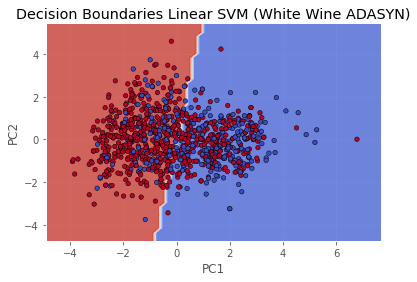

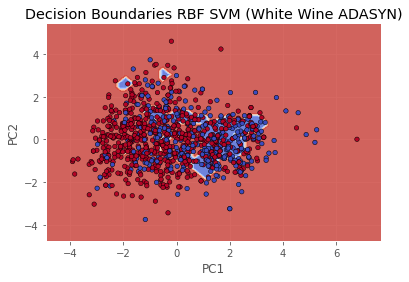

In [50]:
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries Linear SVM (White Wine ADASYN)', clf_w_linear)
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries RBF SVM (White Wine ADASYN)', clf_w_rbf)

In [51]:
SVM_acc_scores_linear = pd.DataFrame(np.round(SVM_acc_linear, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM linear'])
SVM_acc_scores_linear

,Red Wine,White Wine,White wine adasyn
SVM linear,0.71,0.68,0.69


In [52]:
SVM_acc_scores_rbf = pd.DataFrame(np.round(SVM_acc_rbf, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM rbf'])
SVM_acc_scores_rbf

,Red Wine,White Wine,White wine adasyn
SVM rbf,0.71,0.73,0.77


In [53]:
SVM_f1_scores_linear = pd.DataFrame(np.round(SVM_f1_linear, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM linear'])
SVM_f1_scores_linear

,Red Wine,White Wine,White wine adasyn
SVM linear,0.7,0.21,0.61


In [54]:
SVM_f1_scores_rbf = pd.DataFrame(np.round(SVM_f1_rbf, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM rbf'])
SVM_f1_scores_rbf

,Red Wine,White Wine,White wine adasyn
SVM rbf,0.69,0.53,0.58


### Classification Results 

In [55]:
classification_acc_results = LR_acc_scores.append(SVM_acc_scores_linear).append(SVM_acc_scores_rbf)
classification_acc_results

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.72,0.71,0.71
SVM linear,0.71,0.68,0.69
SVM rbf,0.71,0.73,0.77


In [56]:
classification_f1_results = LR_f1_scores.append(SVM_f1_scores_linear).append(SVM_f1_scores_rbf)
classification_f1_results

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.70,0.43,0.61
SVM linear,0.70,0.21,0.61
SVM rbf,0.69,0.53,0.58


##Regression

Proposed algorithms:
1. Linear Regression
2. Polinomial Regression
3. Ridge Regression
4. Lasso Regression

The regression algorithms will be trained on both PCA applied and PCA not applied sets (without oversampling) and the obtained results will be compared.

In [57]:
def plot_mean_squared_error_per_class(y, y_pred, fig_size=(18,1), title = 'title'):
  res = []
  res_f = []
  y = list(y)
  labels = list(set(y))

  for label in labels:
    ind = [i for i, j in enumerate(y) if j == label]
    y_l = [y[i] for i in range(len(y)) if i in ind]
    y_l_pred = [y_pred[i] for i in range(len(y_pred)) if i in ind]
    res_l = mean_squared_error(y_l, y_l_pred)
    res.append(res_l*-1)

  res_f.append(res)
  fig, ax = plt.subplots(figsize=fig_size)
  rdd = pd.DataFrame(res_f, index = ['MSE'], columns = labels)
  sns.heatmap(rdd, annot=True, cmap='BuGn')
  plt.xlabel('Qualities')
  plt.title(title,fontsize=14)
  plt.show()
  return

def plot_prediction_error_per_class_bar(y, y_pred, fig_size=(7,7), title = 'title'):
  res = []
  res_f = []
  y = list(y)
  
  labels = list(set(y))

  for label in labels:
    ind = [i for i, j in enumerate(y) if j == label]
    y_l = [y[i] for i in range(len(y)) if i in ind]
    y_l_pred = [y_pred[i] for i in range(len(y_pred)) if i in ind]
    y_l_pred_mean = np.mean(y_l_pred)
    y_l_delta = y_l_pred_mean - y_l[0]
    res.append(y_l_delta)

  
  fig, ax = plt.subplots(figsize=fig_size)
  ax.bar([x for x in labels], res)
  plt.xlabel('Qualities')
  plt.title(title,fontsize=14)
  plt.show()
  return

In [58]:
#for Red dataset, wines with quality = 3 and 8 are considered outlier. Same as with wines with quality = 3, 8 and 9 in White wine (see Boxplot)
#---> we remove instances with these quantities
idx_r = list(y_train_r.index)
indexes_r = [i for i in idx_r if i not in quality_r_out] #index_r rappresenta tutti gli indici che sono nel training set e che non inclusi in quelli da rimuovere. 
                                                         #Sono quindi gli indici 'buoni'

X_train_r_std = X_train_r_std.loc[indexes_r]
X_train_r_reduced = X_train_r_reduced.loc[indexes_r]
y_train_r = y_train_r.loc[indexes_r]


idx_w = list(y_train_w.index)
indexes_w = [i for i in idx_w if i not in quality_w_out]

X_train_w_std = X_train_w_std.loc[indexes_w]
X_train_w_reduced = X_train_w_reduced.loc[indexes_w]
y_train_w = y_train_w.loc[indexes_w]

### Linear Regression

In [59]:
lr_mse = np.zeros((1,4))

#### PCA dataset

Overall mean squared error Red wines (PCA): 0.42


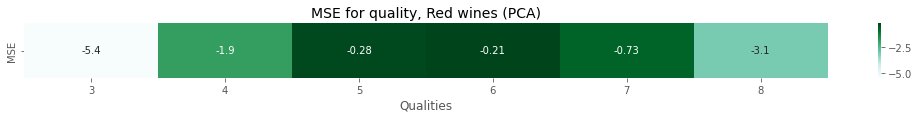

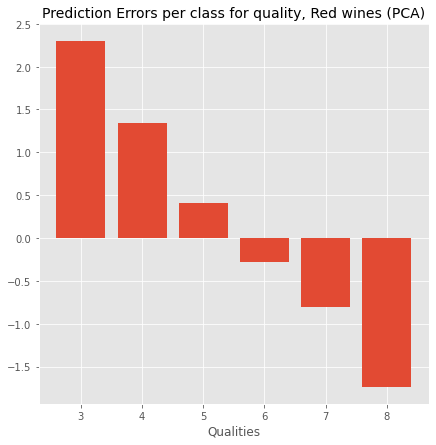

In [60]:
reg = LinearRegression()
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 
MSE = mean_squared_error(y_test_r, y_pred)

lr_mse[0,0] = MSE

print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')

Overall mean squared error White wines (PCA): 0.68


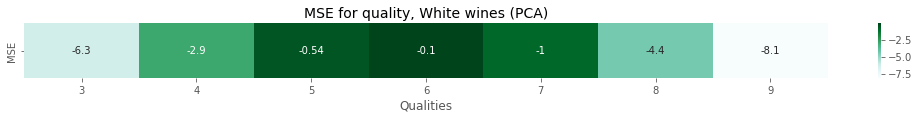

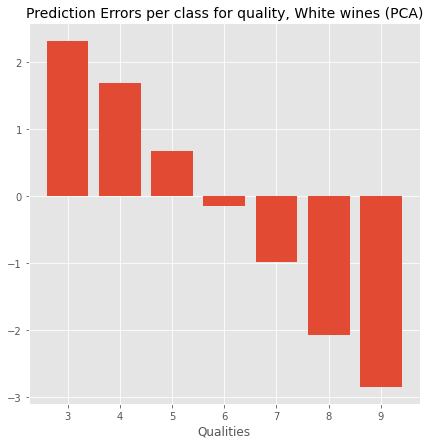

In [61]:
reg = LinearRegression()
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 
MSE = mean_squared_error(y_test_w, y_pred)

lr_mse[0,2] = MSE

print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')

#### No PCA dataset

Overall mean squared error Red wines (no PCA): 0.40


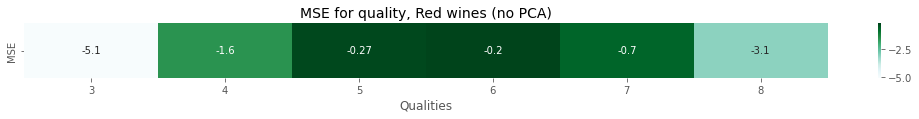

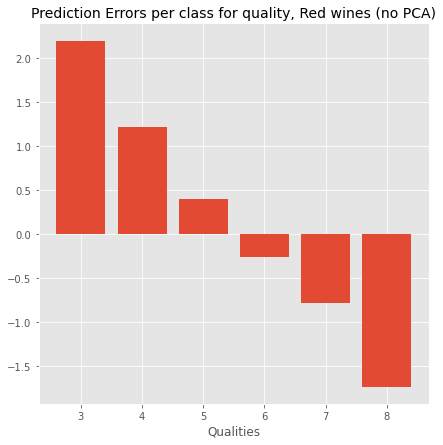

In [62]:
reg = LinearRegression()
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 
MSE = mean_squared_error(y_test_r, y_pred)

lr_mse[0,1] = MSE

print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')

Overall mean squared error White wines (no PCA): 0.59


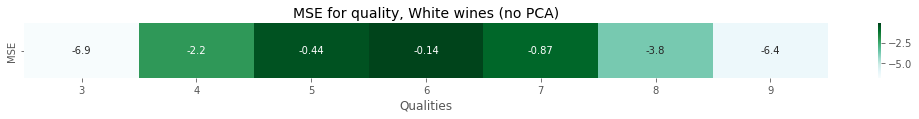

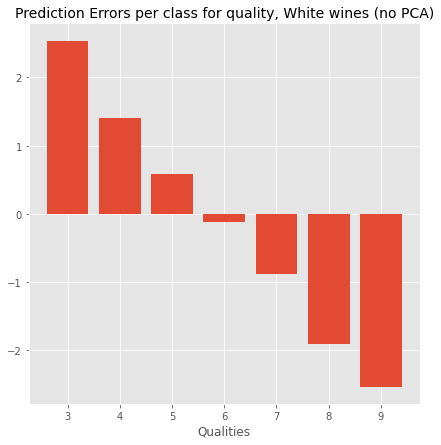

In [63]:
reg = LinearRegression()
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 
MSE = mean_squared_error(y_test_w, y_pred)

lr_mse[0,3] = MSE

print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')

In [64]:
lr__mse_scores = pd.DataFrame(lr_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Linear Regression'])
lr__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Linear Regression,0.420843,0.397168,0.678496,0.593659


### Polinomial Regression

In [65]:
pr_mse = np.zeros((1,4))

#### PCA dataset

Overall mean squared error Red wines (PCA): 0.43


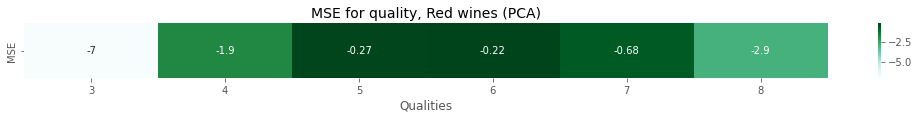

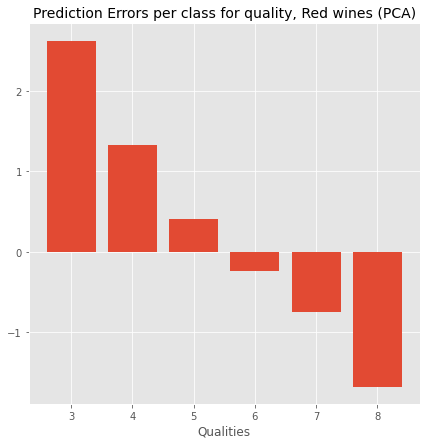

In [66]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 

MSE = mean_squared_error(y_test_r, y_pred)
pr_mse[0,0] = MSE

print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')

Overall mean squared error White wines (PCA): 0.62


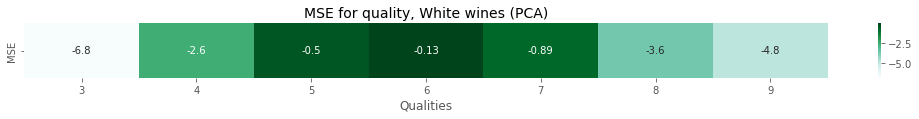

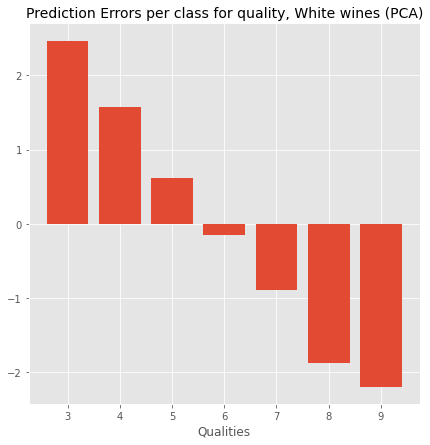

In [67]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 

MSE = mean_squared_error(y_test_w, y_pred)
pr_mse[0,2] = MSE

print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')

#### No PCA dataset

Overall mean squared error Red wines (no PCA): 0.40


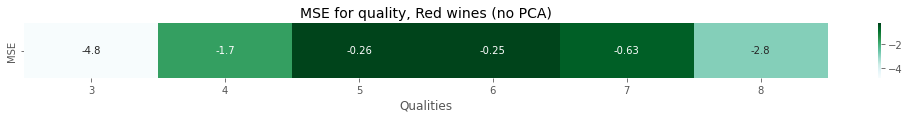

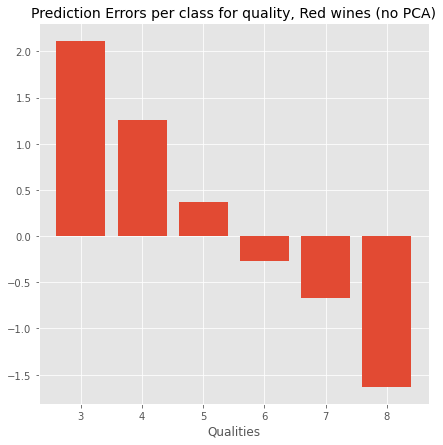

In [68]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 

MSE = mean_squared_error(y_test_r, y_pred)
pr_mse[0,1] = MSE

print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')

Overall mean squared error White wines (no PCA): 0.57


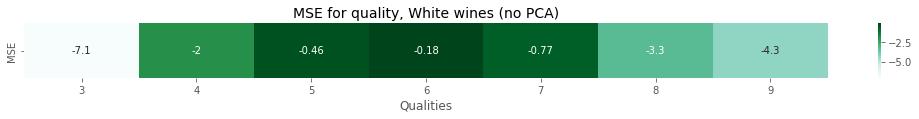

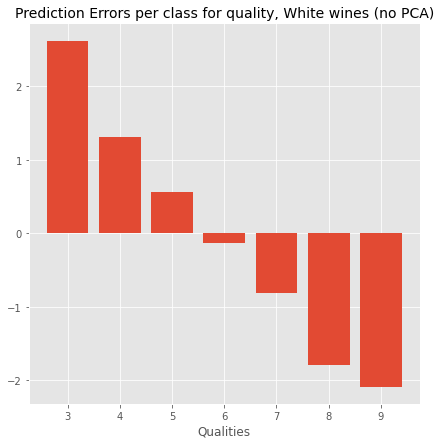

In [69]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 

MSE = mean_squared_error(y_test_w, y_pred)
pr_mse[0,3] = MSE

print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')

In [70]:
pr__mse_scores = pd.DataFrame(pr_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Polinomial Regression'])
pr__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Polinomial Regression,0.426206,0.404372,0.615926,0.57438


### Ridge Regression

In [71]:
rr_mse = np.zeros((1,4))

parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100,1000]}
scoring = 'neg_mean_squared_error'

#### PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 10}
Overall mean squared error Red wines (PCA): 0.42


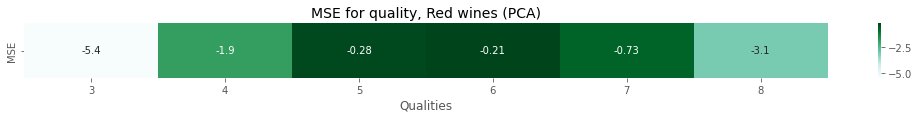

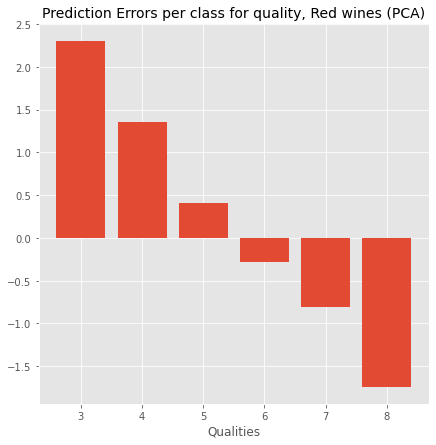

In [72]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 
MSE = mean_squared_error(y_test_r, y_pred)

rr_mse[0,0] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 100}
Overall mean squared error White wines (PCA): 0.68


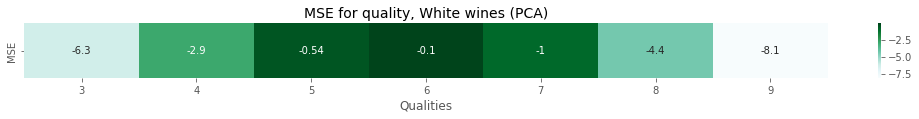

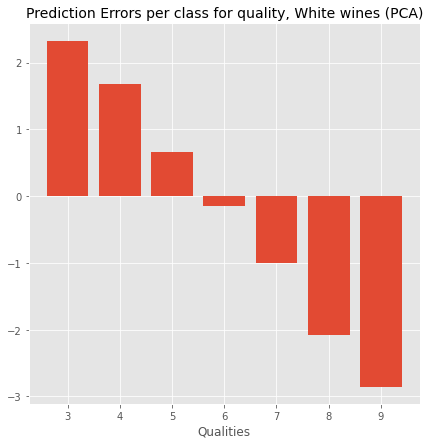

In [73]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 
MSE = mean_squared_error(y_test_w, y_pred)

rr_mse[0,2] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')


#### No PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 10}
Overall mean squared error Red wines (no PCA): 0.40


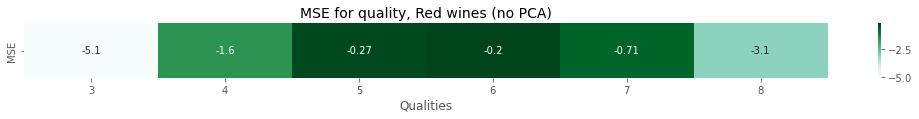

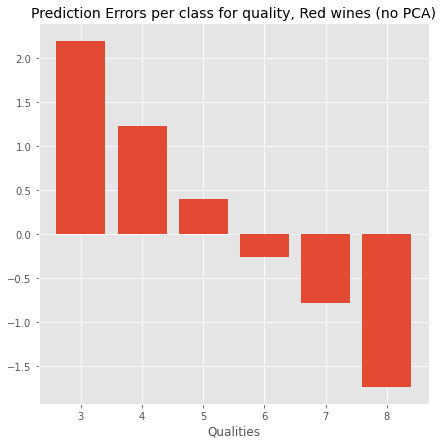

In [74]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 
MSE = mean_squared_error(y_test_r, y_pred)

rr_mse[0,1] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 100}
Overall mean squared error White wines (no PCA): 0.60


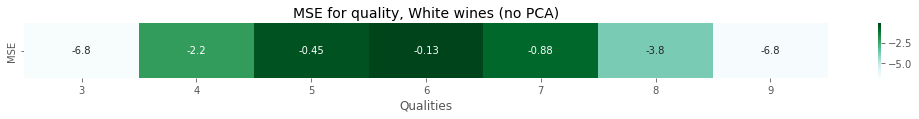

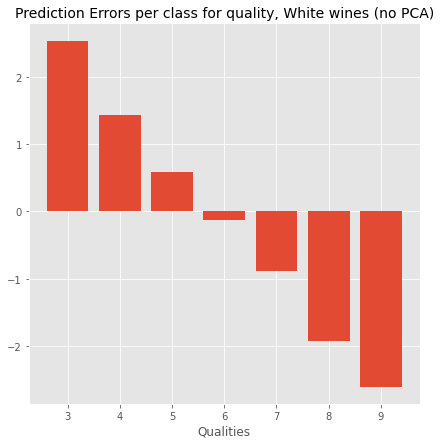

In [75]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 
MSE = mean_squared_error(y_test_w, y_pred)

rr_mse[0,3] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')


In [76]:
rr__mse_scores = pd.DataFrame(rr_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Ridge Regression'])
rr__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Ridge Regression,0.421036,0.397518,0.678434,0.596589


### Lasso Regression

In [77]:
lasso_r_mse = np.zeros((1,4))

parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100,1000]}
scoring = 'neg_mean_squared_error'

#### PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.001}
Overall mean squared error Red wines (PCA): 0.42


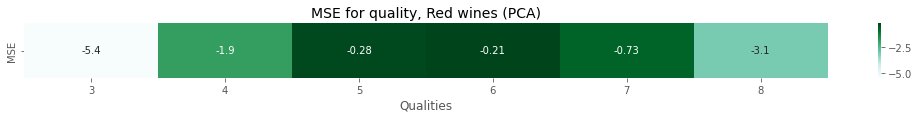

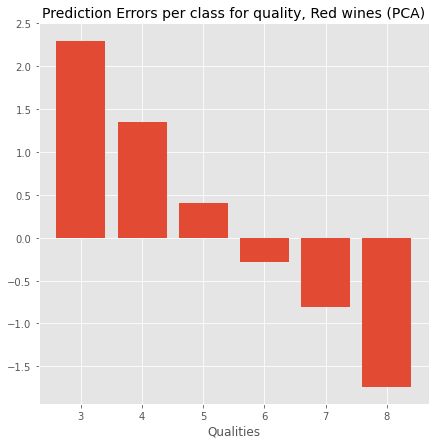

In [78]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 
MSE = mean_squared_error(y_test_r, y_pred)

lasso_r_mse[0,0] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.01}
Overall mean squared error White wines (PCA): 0.68


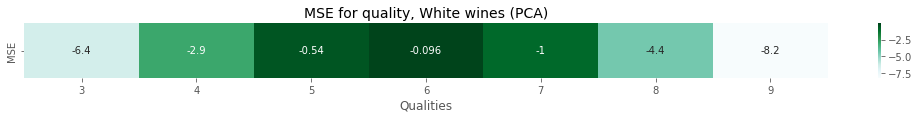

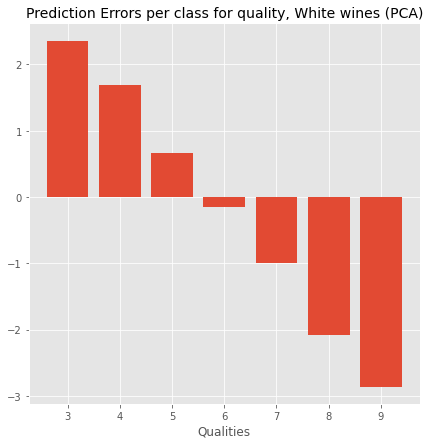

In [79]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 
MSE = mean_squared_error(y_test_w, y_pred)

lasso_r_mse[0,2] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')


#### No PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.001}
Overall mean squared error Red wines (no PCA): 0.40


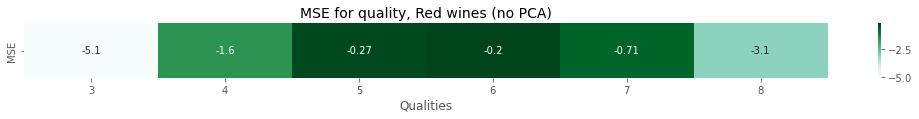

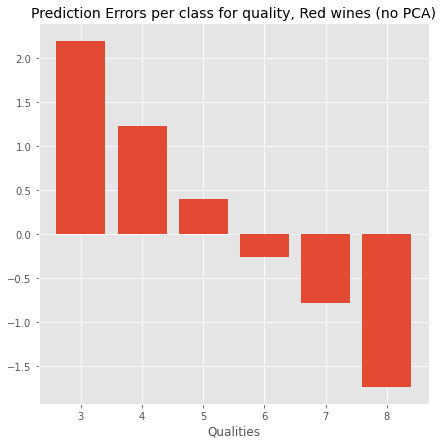

In [80]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 
MSE = mean_squared_error(y_test_r, y_pred)

lasso_r_mse[0,1] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.001}
Overall mean squared error White wines (no PCA): 0.59


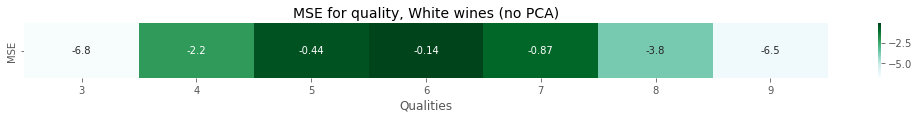

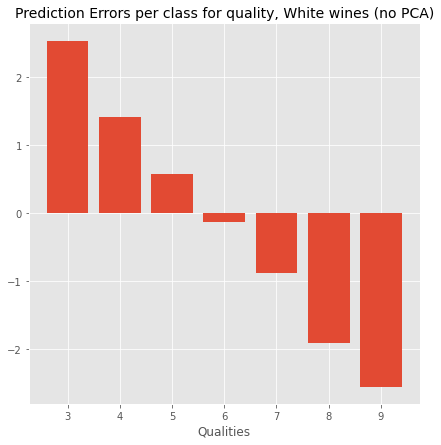

In [81]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 
MSE = mean_squared_error(y_test_w, y_pred)

lasso_r_mse[0,3] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')


In [82]:
lasso_r__mse_scores = pd.DataFrame(lasso_r_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Lasso Regression'])
lasso_r__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Lasso Regression,0.420956,0.397695,0.67979,0.594112


### Regression Results 

In [83]:
regression_mse_results = lr__mse_scores.append(pr__mse_scores).append(rr__mse_scores).append(lasso_r__mse_scores) 
regression_mse_results

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Linear Regression,0.420843,0.397168,0.678496,0.593659
Polinomial Regression,0.426206,0.404372,0.615926,0.574380
Ridge Regression,0.421036,0.397518,0.678434,0.596589
Lasso Regression,0.420956,0.397695,0.679790,0.594112
